## Анализ оттока клиентов Банка

**Заказчик:** 

отдел маркетинга банка «Метанпромбанк»

**Цель проекта:** 

Анализ клиентов регионального банка и выделие сегментов клиентов,
которые склонны уходить из банка для дальнейших мер по снижению оттока и сохранению текущих клиентов.

**Входные данные:**

Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск. Данные о клиентах банка «Метанпром» содержатся в датасете /datasets/bank_scrooge.csv, доступ к которому можно получить из интернета по адресу https://code.s3.yandex.net/datasets/.\
Итак, в датасете представлены следующие колонки:\
•	USERID — идентификатор пользователя,\
•	score — баллы кредитного скоринга,\
•	city — город,\
•	gender — пол,\
•	age — возраст,\
•	equity — количество баллов собственности\
•	balance — баланс на счёте,\
•	products — количество продуктов, которыми пользуется клиент,\
•	credit_card — есть ли кредитная карта,\
•	last_activity — активный клиент,\
•	EST_SALARY — оценочный доход клиента,\
•	сhurn — признак оттока.

**Ход анализа:**

• Обзор и предобработка данных;\
• Исследовательский анализ данных;\
• Проверка гипотез;\
• Сегментация клиентов Банка;\
• Выводы и рекомендации для Заказчика;\
• Презентация

In [1]:
# импортируем библиотеки
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

### Шаг 1. Загрузка данных

In [2]:
# загрузим данные из CSV-файла в переменную
data = pd.read_csv('C:/Users/nata/Downloads/bank_scrooge.csv')

In [3]:
# выведим таблицу с помощью функции display
display(data)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27.0,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46.0,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24.0,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68.0,3,865457.97,3,0,1,86874.90,0


In [4]:
# выведим основную информацию о датафрейме с помощью метода info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [5]:
# проверим датасет на наличие пропусков
data.isna().sum()

USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64

In [6]:
# посмотрим на процент этих пропущенных значений в столбцах
(data.isna().sum()/len(data)).apply('{:.1%}'.format)

USERID            0.0%
score             0.0%
city              0.0%
gender            0.0%
age               0.3%
equity            0.0%
balance          22.9%
products          0.0%
credit_card       0.0%
last_activity     0.0%
EST_SALARY        0.0%
churn             0.0%
dtype: object

**Промежуточные итоги:**

Изучив общую информацию о датасете, мы выяснили, что:\
• таблица содержит 12 столцов и 10 000 срок;\
• необходимо отредактировать названия колонок;\
• частично преобразовать тип данных;\
• есть пропуски в некоторых столбцах.

Перед тем как приступить к анализу необходимо подготовить данные, а именно:\
• переименуем названия некоторых колонок, используя «змеиный_регистр»;\
• столбцы 'credit_card', 'last_activity' и 'churn' содержат значения 1 и 0, а значит должны иметь булевый тип. А столбец 'age' должен быть целочисленым;\
• проверим на наличие явных и неявных дубликатов. Обработаем их, если такие значения присутствуют;\
• столбцы 'age', 'balance' содержат пропуски. С учетом того, что пропусков в столбце 'age' меньше 1%, то просто отбросим их, а вот пропусков в столбце 'balance' 22,9%. Это повод для изучения, так как без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям.

### Шаг 2. Предобработка данных

In [7]:
# переименуем название колонок
data = data.rename(
    columns={'USERID': 'user_id', 'EST_SALARY': 'est_salary'})
data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

In [8]:
# меняем типы данных в некоторых столбцах
data['credit_card'] = data['credit_card'].astype('bool') 
data['last_activity'] = data['last_activity'].astype('bool') 
data['churn'] = data['churn'].astype('bool')
data.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  bool   
 9   last_activity  10000 non-null  bool   
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  bool   
dtypes: bool(3), float64(4), int64(3), object(2)
memory usage: 732.6+ KB


In [9]:
# какие уникальные значения в столбце 'products'
data['products'].unique()

array([2, 3, 1, 4, 5, 0], dtype=int64)

Так, как в нашем датасете только актуальные данные, т.е. все клиенты на данный момент являются действующими, а значит у них есть минимум один продукт. Выясним количество таких клиентов, и если их меньше 5% от общего числа, то отбросим их.

In [10]:
print('Количество клиентов в датасете без единого банковского продукта от общего числа =' "{:.2%}".format(len(data.query('products == 0')) / len(data)))

Количество клиентов в датасете без единого банковского продукта от общего числа =0.01%


In [11]:
# отбросим данные по клиентам без единого продукта
data = data.query('products != 0')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9999 non-null   int64  
 1   score          9999 non-null   float64
 2   city           9999 non-null   object 
 3   gender         9999 non-null   object 
 4   age            9973 non-null   float64
 5   equity         9999 non-null   int64  
 6   balance        7705 non-null   float64
 7   products       9999 non-null   int64  
 8   credit_card    9999 non-null   bool   
 9   last_activity  9999 non-null   bool   
 10  est_salary     9999 non-null   float64
 11  churn          9999 non-null   bool   
dtypes: bool(3), float64(4), int64(3), object(2)
memory usage: 810.5+ KB


In [12]:
# выведим количество строк-дубликатов (явных) в данных 
print('Количество строк-дубликатов =', data.duplicated().sum())

Количество строк-дубликатов = 0


In [13]:
# проверим на неявные дубликаты в столбцах 'user_id'
(print('Количество дубликатов пользователей =', data.duplicated(subset=['user_id']).sum(), 
       ', что составляет', "{:.2%}".format(data['user_id'].duplicated().sum() / len(data)), 'об общего числа данных'))

Количество дубликатов пользователей = 73 , что составляет 0.73% об общего числа данных


In [14]:
# посмотрим, что из себя представляют клиенты с дублированным user_id, добавив для полной их индетефикации возраст и пол
display(data[data.duplicated(['user_id', 'age', 'gender'], False)])

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3274,155765,863.0,Ярославль,М,30.0,5,1036114.50,5,True,True,150744.50,True
5197,155765,923.0,Рыбинск,М,30.0,0,NaN,1,True,True,120296.60,False
8205,227795,840.0,Рыбинск,М,34.0,2,350768.03,1,True,False,102036.14,True
8497,227795,839.0,Ярославль,М,34.0,2,326593.14,2,True,False,103314.92,False


In [15]:
(print('Количество неявных дубликатов пользователей составляет =', "{:.2%}".format(data.duplicated(subset=['user_id', 'age', 'gender']).sum() / len(data)), 'об общего числа данных'))

Количество неявных дубликатов пользователей составляет = 0.02% об общего числа данных


In [16]:
# отбросим эти четыре строки, 
# а остальные строки оставим возможно дублированные id возникли при выгрузке данных из разных источников, 
# так как остальные параментры не совпадают 
data = data.drop_duplicates(subset=['user_id', 'age', 'gender'])

Количество пропущенных значений в столбце "age" меньше одного процента, удаление этих данных никак не повлиет на аналитику. Так сделаем это.

In [17]:
# удалим строки с пропусками в столбце (их 0,3% от общего числа данных)  и преобразуем тип данных на 'int'
data = data.dropna(subset=['age'])
data['age'] = data['age'].astype('int')

In [18]:
# сделаем копию оригигнальных столбцов 'city' и 'gender', чтобы не потерять оригинальный столбец
data['city_copy'] = data['city']
data['gender_copy'] = data['gender']

In [19]:
# закодируем категориальные данные уолонок 'city_copy' и 'gender_copy' численно
data = pd.get_dummies(data, columns = ['city_copy'])
data = pd.get_dummies(data, columns = ['gender_copy'], drop_first=True)
display(data)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_copy_Ростов,city_copy_Рыбинск,city_copy_Ярославль,gender_copy_М
0,183012,850.0,Рыбинск,Ж,25,1,59214.82,2,False,True,75719.14,True,False,True,False,False
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,True,False,86621.77,False,False,True,False,False
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,True,True,107683.34,False,False,True,False,False
3,225363,866.0,Ярославль,Ж,51,5,1524746.26,2,False,True,174423.53,True,False,False,True,False
4,157978,730.0,Ярославль,М,34,5,174.00,1,True,False,67353.16,True,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27,1,78144.65,1,False,True,18943.64,False,False,True,False,True
9996,139170,894.0,Ярославль,М,46,0,NaN,1,True,False,196898.29,False,False,False,True,True
9997,115639,903.0,Ярославль,М,24,0,NaN,2,True,True,108905.09,False,False,False,True,True
9998,148700,777.0,Ярославль,Ж,68,3,865457.97,3,False,True,86874.90,False,False,False,True,False


In [20]:
# переименуем новые столбцы для удобства
data = data.rename (
    columns = ({
        'city_copy_Ростов':'rostov', 'city_copy_Рыбинск':'rybinsk','city_copy_Ярославль':'yaroslavl', 
        'gender_copy_Ж':'female', 'gender_copy_М':'male'}))

In [21]:
# проверим пропуски в столбце 'balance'
# сравним статистические показатели для двух наборов данных (с пропущенными и заполненным значениями в столбце 'balance')

In [22]:
# статистические показатели для набор данных с заполненными значениями в 'balance'
data[data['balance'].notnull()].describe()

,user_id,score,age,equity,balance,products,est_salary
count,7694.000000,7694.000000,7694.000000,7694.000000,7.694000e+03,7694.000000,7.694000e+03
mean,171703.602937,843.744736,42.925526,3.394983,8.273107e+05,2.081232,1.245232e+05
std,33809.013024,55.346109,12.244383,1.584840,1.980448e+06,0.757495,1.046736e+05
min,94561.000000,689.000000,18.000000,0.000000,0.000000e+00,1.000000,2.546300e+03
25%,142637.500000,801.000000,33.000000,2.000000,2.956339e+05,2.000000,6.755439e+04
50%,172707.000000,840.000000,40.000000,4.000000,5.243565e+05,2.000000,1.062503e+05
75%,201132.500000,882.000000,52.000000,5.000000,9.803785e+05,2.000000,1.551624e+05
max,229136.000000,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.395064e+06


In [23]:
# статистические показатели для набор данных с пропусками в 'balance'
data[data['balance'].isnull()].describe()

,user_id,score,age,equity,balance,products,est_salary
count,2277.000000,2277.000000,2277.000000,2277.000000,0.0,2277.000000,2.277000e+03
mean,171922.544137,865.289416,42.082126,0.050066,NaN,1.163812,2.264804e+05
std,33312.302246,89.561994,11.919023,0.218129,NaN,0.403139,1.998564e+05
min,114182.000000,642.000000,18.000000,0.000000,NaN,1.000000,2.027403e+04
25%,142981.000000,871.000000,33.000000,0.000000,NaN,1.000000,1.202605e+05
50%,172448.000000,903.000000,40.000000,0.000000,NaN,1.000000,1.743606e+05
75%,201260.000000,922.000000,49.000000,0.000000,NaN,1.000000,2.404211e+05
max,229145.000000,990.000000,86.000000,1.000000,NaN,3.000000,1.333687e+06


**Промежуточные итоги:**
Мы проверили пропуски в столбце 'balance'.\
После сравнения статистических показателей для двух наборов данных (с пропущенными и заполненными значениями в столбце 'balance') выявили следующие:\
• показатели этих признаков 'score', 'age', 'rostov', 'rybinsk', 'yaroslavl', 'gender_clients' для клиентов из двух наборов данных не значительно отличаются,\
• показатели этих признаков 'equity', 'products' и 'est_salary' для клиентов из двух наборов данных значительно отличаются.\
Т.е. для клиентов с пропусками в 'balance' значения этих показателей ниже. Можно преположить, несолько вариантов таких, как для них этот Банк не основной или они имеют один банковский продукт (и это кредитная история. т.е. эти люди малообеспеченнные поэтому их показатели не высокие).

Точной уверенности у нас нет, оставим эти пропуки, как есть, но обратить на это внимание коллег, кто предоставили эти данные, ведь это порой могут быть ошибки системы или процесса выгрузки.  
</div>    

**Промежуточные итоги:**

Мы:\
• переименовали названия некоторых колонок на 'user_id', 'est_salary', соблюдая хороший стиль;\
• преобрзовали тип данных у столбцов 'credit_card', 'last_activity' и 'churn' на булевый тип, а у столбца 'age' - на целочисленный;\
• отбросили неактуальные данные (это 0.01% от общего количество данных), т.е. в текущих данных представлены клиенты, у которых есть минимум один продукт;    
• выявили неявные дублекаты ( 0.02% об общего числа данных) и отбросил их, а вот явных дубликатов не обнаружили;\
• отбросили данный с пропусками в столбце 'age' (изначально их было 0,3% от общего числа данных);\
• закодировали переменные для нашего удобства в работе с ними, т.е. в таблице с данными добавили новые столбцы (все города и пол клиентов);\
• данный с пропусками в столбце 'balance' проанализировали, и можно предположить, что это связано с тем, что у клиентов это не основной банк или то, что у клиентов один банковский продукт - и это кредитная карта. Так как точной уверенности у нас нет, оставим эти пропуки, как есть, но обратить на это внимание коллег, кто предоставили эти данные, ведь это порой могут быть ошибки системы или процесса выгрузки.

### Шаг. 3. Исследовательский анализ данных 

#### 3.1. Исследуем портреты типичного текущего клиента банка и того клиента, который склонен уйти из банка (средние и медианы)

Портрет клиента собререм в виде таблицы меры центральной тендецнии, описывающие портреты клиентов по каждому признаку. А после между сегментами посчитаем относительную разницу.\
Таблица будет собрана, учитывая:\
. среднее будем использовать для непрерывных величин. Также если у непрерывной величины есть выбросы, вместо среднего посчитаем медиану;\
. что касается дискретных признаков - будем использовать медиану;\
. закодированные признаки в портрете клиента не будем использовать, а будем использвать исходные категориальные признаки и их значения моды.\
Относительную разницу для моды и медианы считать не будем.

In [24]:
# изучим непрерывные величины на наличие у них выбросов
data[['score', 'age', 'equity', 'balance', 'products', 'est_salary']].describe()

,score,age,equity,balance,products,est_salary
count,9971.000000,9971.000000,9971.000000,7.694000e+03,9971.000000,9.971000e+03
mean,848.664728,42.732925,2.631130,8.273107e+05,1.871728,1.478063e+05
std,65.395403,12.175406,1.980074,1.980448e+06,0.792577,1.393001e+05
min,642.000000,18.000000,0.000000,0.000000e+00,1.000000,2.546300e+03
25%,802.000000,33.000000,0.000000,2.956339e+05,1.000000,7.525178e+04
50%,853.000000,40.000000,3.000000,5.243565e+05,2.000000,1.196431e+05
75%,900.000000,51.000000,4.000000,9.803785e+05,2.000000,1.745011e+05
max,1000.000000,86.000000,9.000000,1.191136e+08,5.000000,1.395064e+06


Выбросы (там где медиана и среднее арифметическое сильно различаться) - это параметры 'balance', 'est_salary'. Значит в портрете клиента для этих величин будем использовать медиану.

In [25]:
# выведем сводную таблицу с мерами центральной тендецнии, описывающие портреты обоих клиентов
central_trends = data.groupby('churn').agg({
                         'score': 'mean',
                         'city': pd.Series.mode,
                         'gender': pd.Series.mode,
                         'age': 'mean',
                         'equity': 'mean',
                         'balance': 'median',
                         'products': 'mean', 
                         'credit_card': 'median', 
                         'last_activity': 'median', 
                         'est_salary': 'median',
                         
                         }).round().reset_index()
display(central_trends)

,churn,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary
0,False,845.0,Ярославль,Ж,43.0,2.0,475438.0,2.0,1.0,0.0,118228.0
1,True,863.0,Ярославль,М,41.0,4.0,783909.0,2.0,1.0,1.0,125409.0


In [26]:
dt1 = "{:.2%}".format(1-central_trends.loc[0, 'score'] / central_trends.loc[1, 'score'])
dt2 = "{:.2%}".format(1-central_trends.loc[0, 'age'] / central_trends.loc[1, 'age'])
dt3 = "{:.2%}".format(1-central_trends.loc[0, 'equity'] / central_trends.loc[1, 'equity'])
dt4 = "{:.2%}".format(1-central_trends.loc[0, 'products'] / central_trends.loc[1, 'products'])
central_trends.loc[len(central_trends.index )] = ['-', dt1, '-', '-', dt2, dt3, '-', dt4, '-', '-', '-']
display(central_trends)

,churn,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary
0,False,845.0,Ярославль,Ж,43.0,2.0,475438.0,2.0,1.0,0.0,118228.0
1,True,863.0,Ярославль,М,41.0,4.0,783909.0,2.0,1.0,1.0,125409.0
2,-,2.09%,-,-,-4.88%,50.00%,-,0.00%,-,-,-


In [27]:
# для удобства переформируем сводную таблицу
display(pd.concat({'Лояльный': central_trends.iloc[0], 'Отточный': central_trends.iloc[1], 'Относительная разница': central_trends.iloc[2] }, axis = 1))

,Лояльный,Отточный,Относительная разница
churn,False,True,-
score,845.0,863.0,2.09%
city,Ярославль,Ярославль,-
gender,Ж,М,-
age,43.0,41.0,-4.88%
equity,2.0,4.0,50.00%
balance,475438.0,783909.0,-
products,2.0,2.0,0.00%
credit_card,1.0,1.0,-
last_activity,0.0,1.0,-


**Промежуточные итоги:**

Мы имеем портреты типичного лояльного клиента и клиента, который склонен уйти из банка.

Типичный лояльный клиент (не отточный):\
• женщина, проживающая в Ярославле (gender+city),\
• в возрасте 43 лет (age),\
• имеющая 845.0 баллов кредитного скоринга (score),\
• и количество баллов собственности равное 3.0 (equity),\
• на счету баланс равный 475 438.0 у.е. (balance),\
• пользующаяся 2.0 продуктами банка (products),\
• владеет кредитной картой (credit_card),\
• за последней месяц был не активен (last_activity),\
• оценочный доход клиента равен 118 228.0 у.е. (est_salary).

Типичный клиент, который склонен уйти из банка (отточный):\
• мужчина, проживающий в Ярославле (gender+city),\
• в возрасте 41 года (age),\
• имеющий 863.0 баллов кредитного скоринга (score),\
• и количество баллов собственности равное 4,0 (equity),\
• на счету баланс равный 783 909.0 у.е. (balance),\
• пользующийся 2.0 продуктами банка (products),\
• владеет кредитной картой (credit_card),\
• за последней месяц был активен (last_activity),\
• оценочный доход клиента равен 125 409.0 у.е. (est_salary).


Основные отличия между этими клиентами в разрезе оттока:\
• больше клиентов мужского пола (gender),\
• и они моложе (на -4,88%) (age),\
• у них выше балл кредитного скоринга (на 2,09%) (score),\
• имеют больше баллов собственности (на 50%) (equity),\
• баланс на счету больше (в 1,6 раз) (balance),\
• за последней месяц был активен (last_activity),\
• оценочный доход чуть больше (est_salary).\

Можно сделать вывод, что уходят клиенты более обеспеченные.

#### 3.2. Построим визуализации для непрерывных и категориальных величин

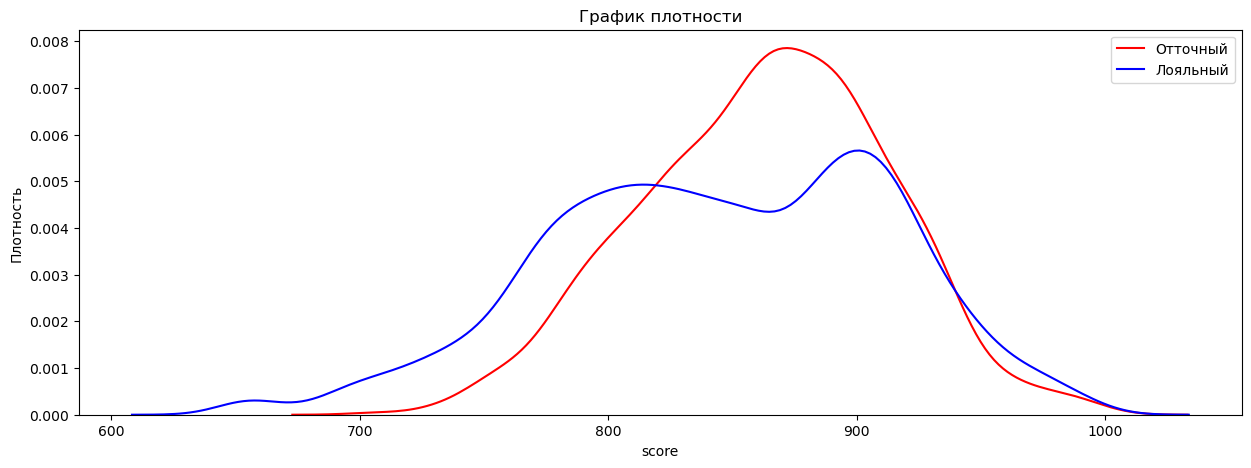

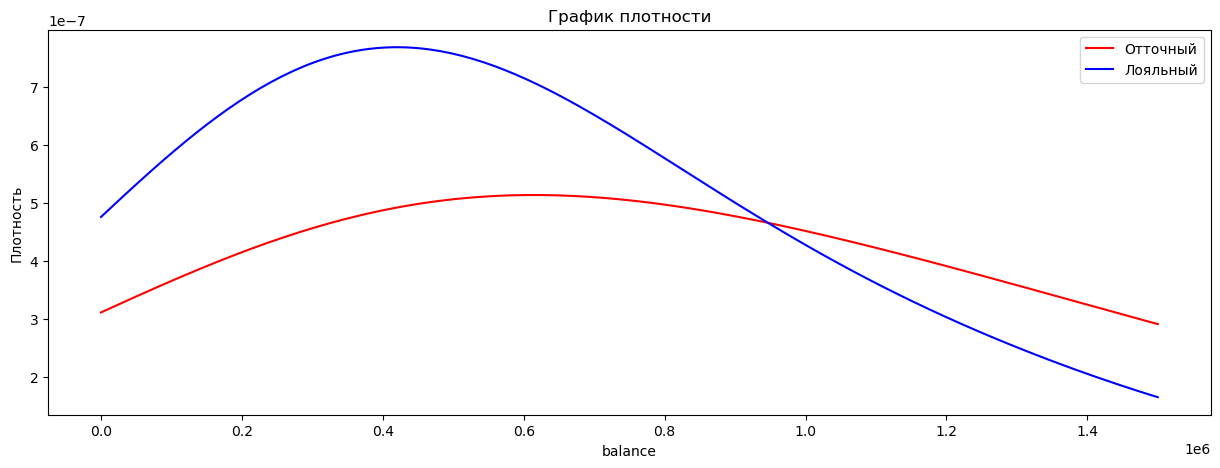

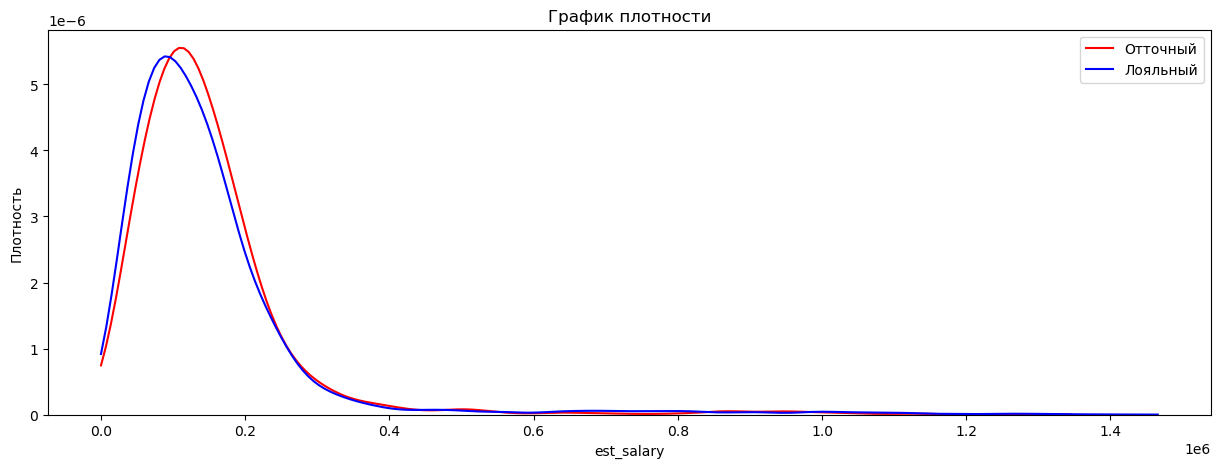

In [28]:
# построим графики плотности для непрерывных переменных в разрезе клиентов Банка (отточных и лояльных)
for i in ['score', 'balance', 'est_salary']:
    plt.figure(figsize=(15,5))
    sns.kdeplot(data, hue='churn', x=i, common_norm=False, palette=['blue', 'red'], clip=(0.0, 1500000.0))
    plt.legend(['Отточный', 'Лояльный'])
    plt.title("График плотности")
    plt.ylabel("Плотность")
    plt.show()

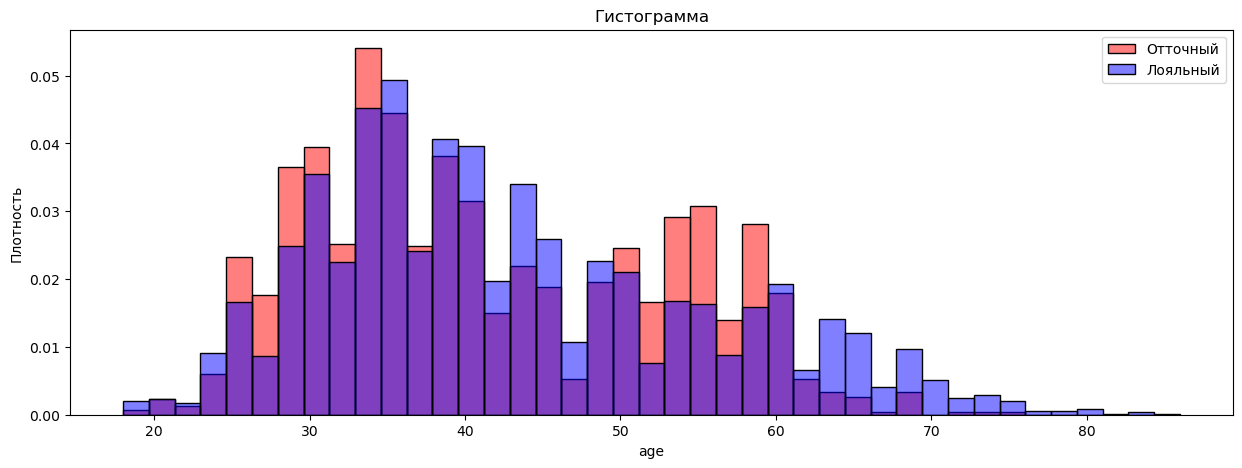

In [29]:
# построим гистограммы для непрерывных переменных в разрезе клиентов Банка (отточных и лояльных)
for i in ['age']:
    plt.figure(figsize=(15,5))
    sns.histplot (data, hue='churn', x=i, stat='density', common_norm=False, palette=['blue', 'red'], alpha=0.5)
    plt.legend(['Отточный', 'Лояльный'])
    plt.title("Гистограмма")
    plt.ylabel("Плотность")
    plt.show()

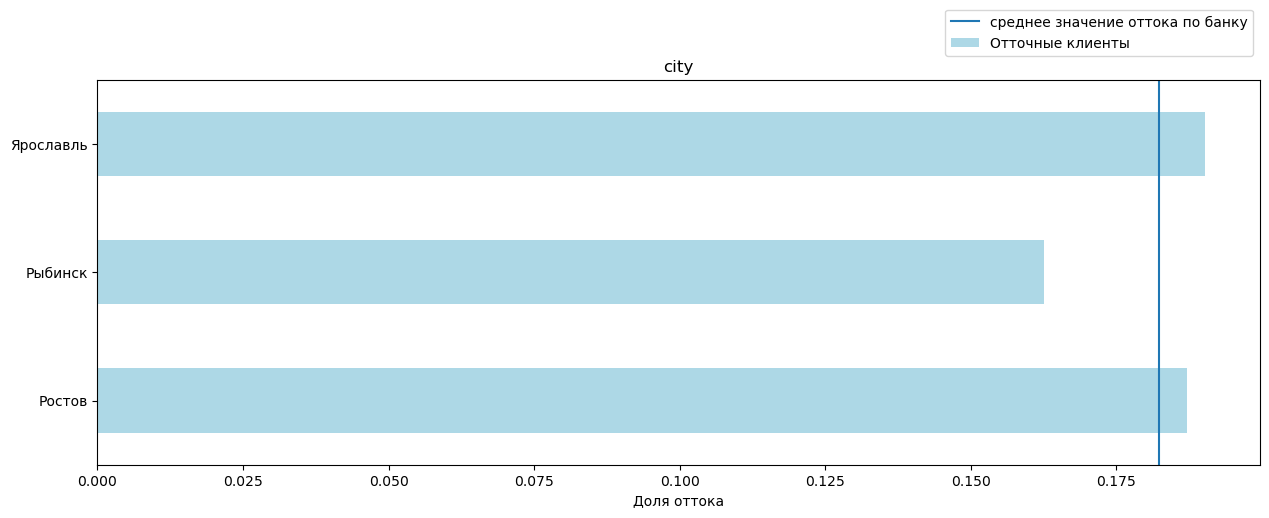

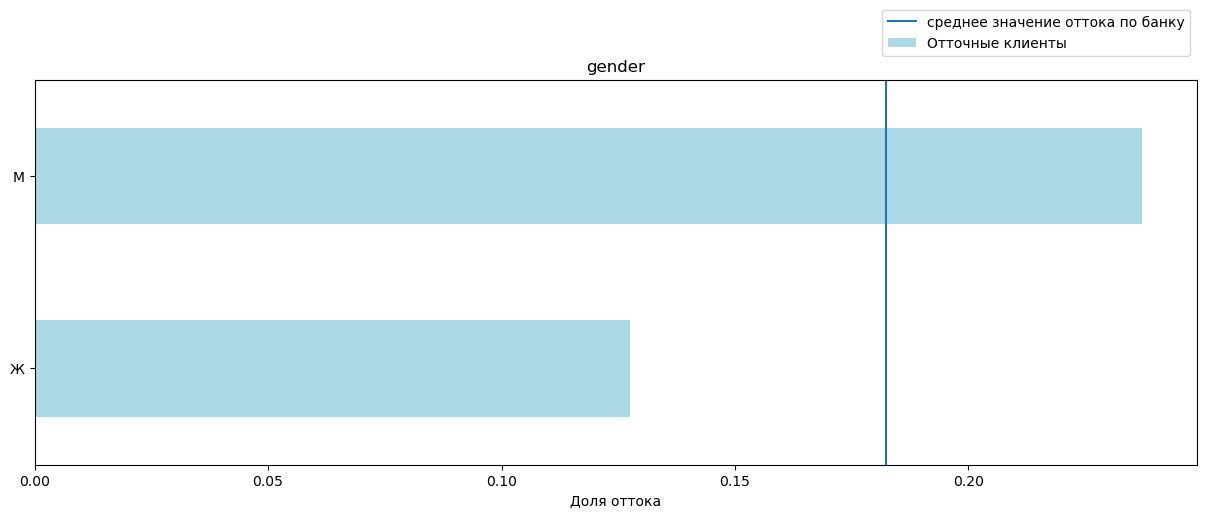

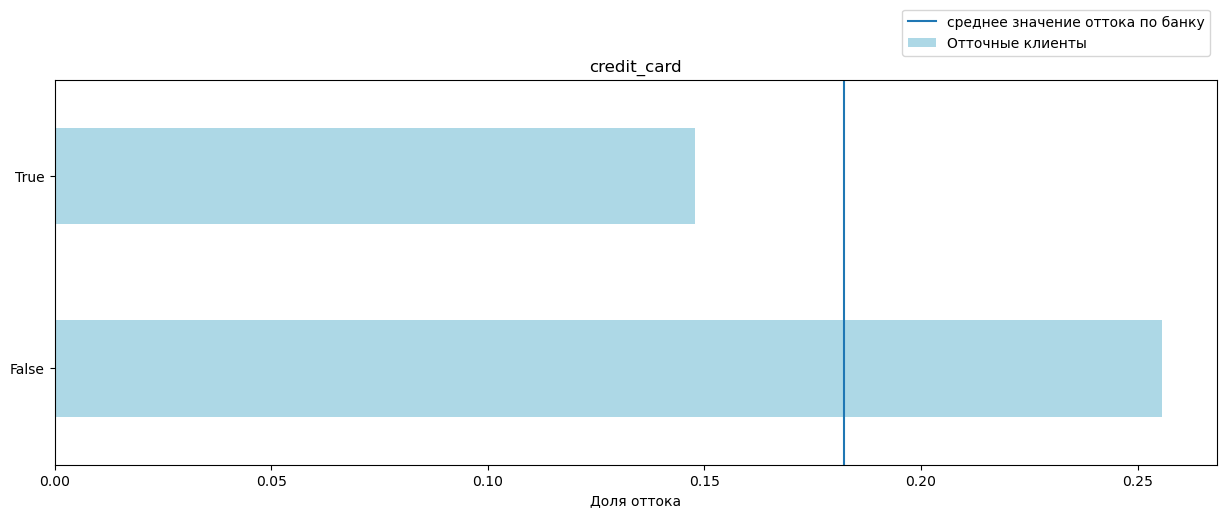

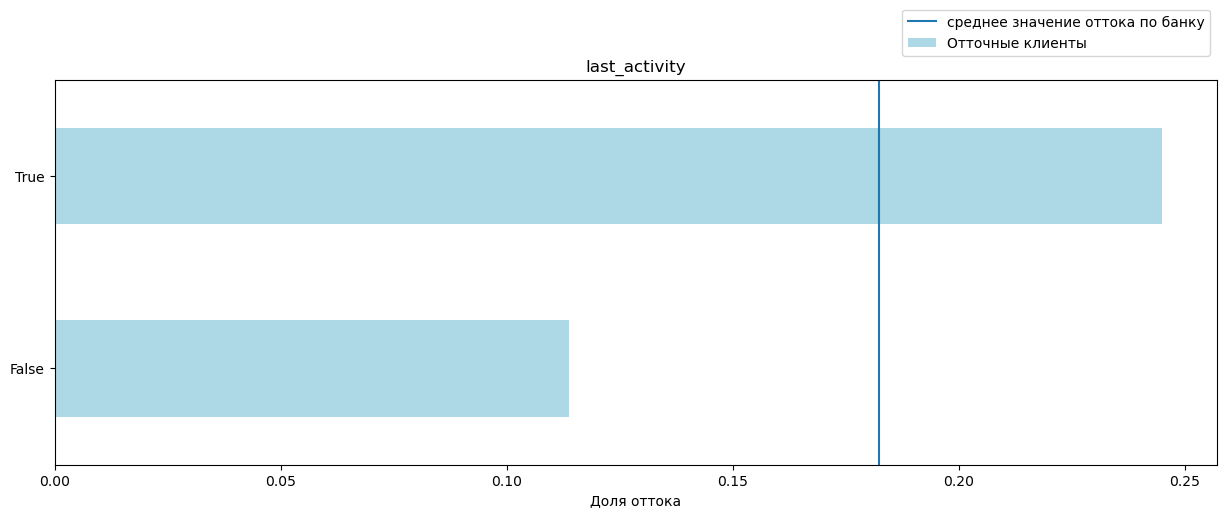

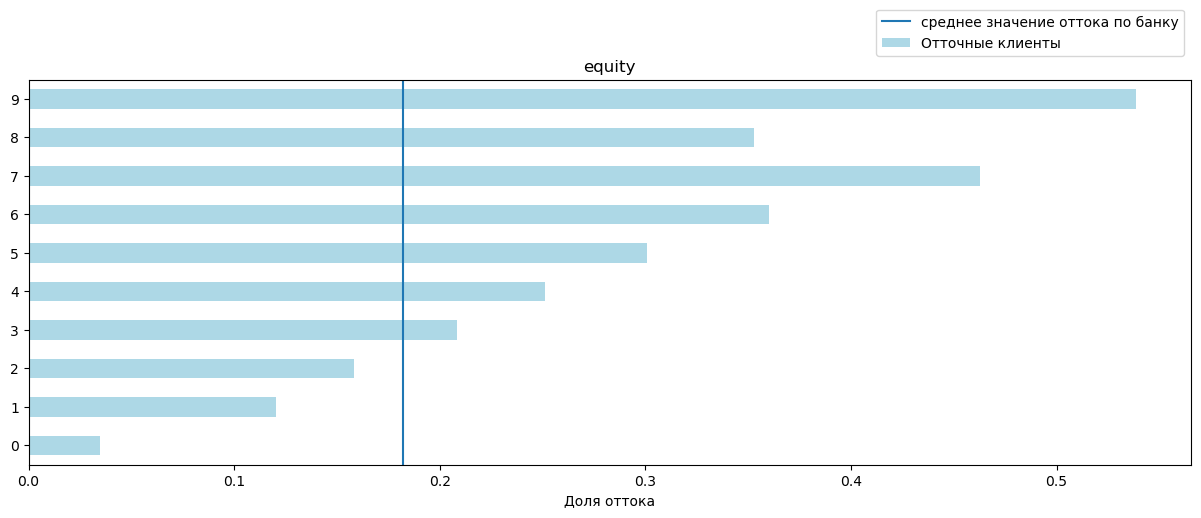

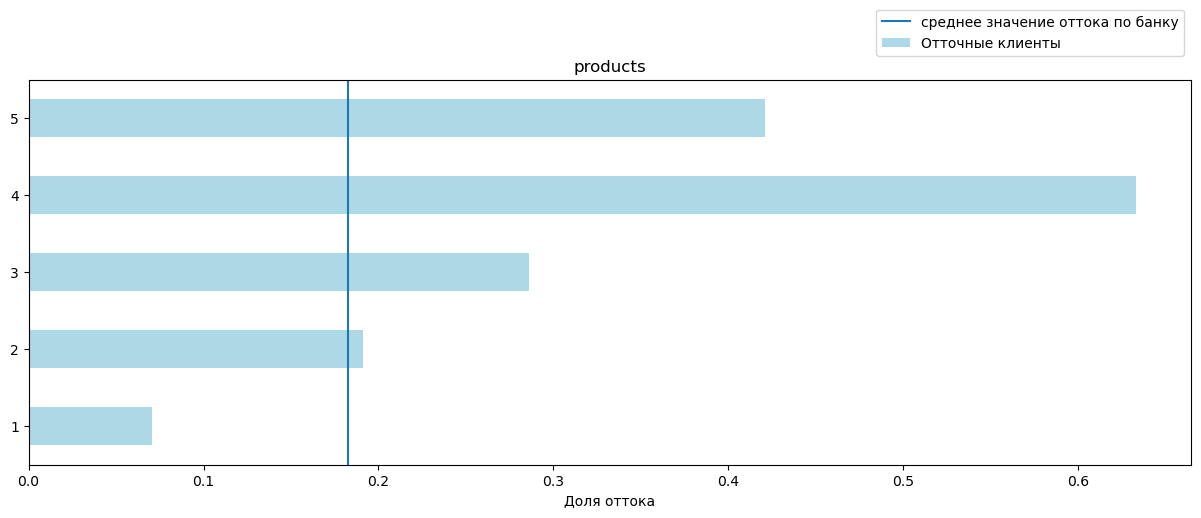

In [30]:
# построим столбиковые диаграммы для категориальных переменных в разрезе отттока клиентов Банка
for i in ['city', 'gender', 'credit_card', 'last_activity', 'equity', 'products']:
    (data.pivot_table(index = i, values = 'churn', aggfunc = 'mean') 
          .plot(kind = 'barh', stacked = True, color=['lightblue'], figsize=(15,5)))
    plt.axvline (x=data['churn'].mean())
    
    plt.title(i)
    #plt.legend(['среднее значение оттока по банку', 'Отточные клиенты'], loc = 'upper right')
    plt.legend(['среднее значение оттока по банку', 'Отточные клиенты'], loc='best', bbox_to_anchor=(0.5, 0.5, 0.5, 0.7))
    plt.xlabel("Доля оттока")
    plt.ylabel("")
    plt.show()
    print()

**Промежуточные итоги:**

С учетом полученных визуализаций выделим признаки, оказывающие наибольшее влияние на отток клиентов Банка:\
• 820-920 баллов кредитного скоринга (score),\
• баланс от 920 тыс. у.с. (balance),\
• оценочный доход в интервале 100 - 210 тыс. у.е. (est_salary),\
• возраст в интервалах 25-35 и 50-60 лет (age),\
• проживающий в Ярославле-Ростове (city),\
• человек мужского пола (gender),\
• не имеющий кредитную карту (credit_card),\
• за последней месяц активен (last_activity),\
• обладающий количество баллов собственности в интервале от 3-9 (самый высокий отток у обладателей 9 баллов собственности)(equity),\
• владеют от 2 до 5-ти продуктами банка (самый высокий отток владельцев 4-х продуктов)(product).

#### 3.3. Корреляционный анализ

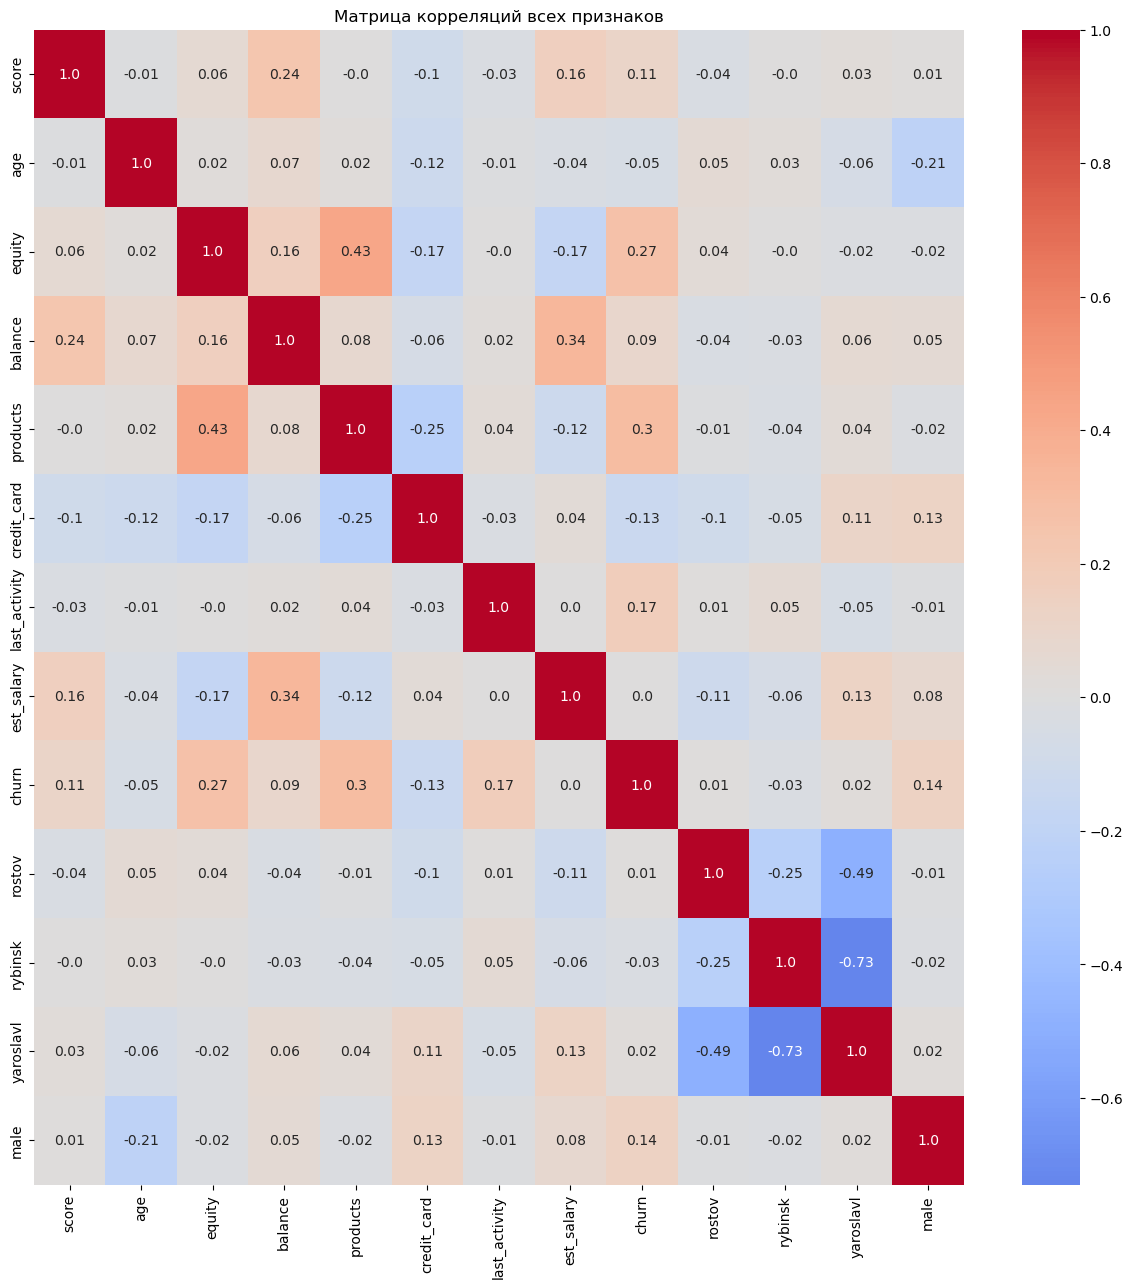

In [31]:
# из анализа данных уберем пару столбцов, так как мы их ранее закодировали и столбец с id
data_corr = data.drop(['user_id', 'city', 'gender'], axis=1)

# оформим матрицу корреляций в виде графика  
plt.figure(figsize=(15, 15))
sns.heatmap(data_corr.corr().round(2), cmap='coolwarm', center=0, annot=True, fmt='', )
plt.title('Матрица корреляций всех признаков') # название графика
plt.show() 

**Промежуточные итоги:**

Итак, коэффициент корреляции может принимать любые значения в диапазоне от -1 до 1.\
Для трактовки силы связи между двумя наблюдаемыми величинами используем шкалу Чеддока.\
Она определяет тесноту связи следующим образом:\
0 – полное отсутствие связи;\
0 – 0.3 – очень слабая;\
0.3 – 0.5 – слабая;\
0.5 – 0.7 – средняя;\
0.7 – 0.9 – высокая;\
0.9 – 1 – очень высокая.


Мы имеем:\
• Очень высокой, высокой и средней связи между двумя наблюдаемыми величинами полностью отсутсвует,

• Слабая связь наблюдается между:\
  product - equity = 0.43\
  est_salary - balance = 0,34
  
  
• Очень слабая связь наблюдается между:  
  churn - product = 0,3\
  churn - equity = 0,27\
  balance - score = 0,24                
  female - age = 0,21\
  и далее по уменьшению до отрицательных значений\
  
Поэтому сегментируя клиентов Банка будем стараться выносить эти признаки (между которыми наблюдается пусть и слабая связь) в разные сегменты, чтобы максимизировать покрытие.


### Шаг. 4. Проверка гипотез

При проверках статистических гипотез используют несолько статистических критериев (t-критерий и u-критерий).\
Перечислим все требования к данным, которые предъявляют эти критерии и проверим, соответствуют ли наши данные этим требованиям.\
Первую гипотезу, о том, влияет ли отток на доходы клиентов, проверим и t-критерием и u-критерием, объясним расхождения, если они возникнут, и выберем, какому критерию стоит доверять сильнее, поясним из-за чего между результатами работы критериев могут возникать расхождения, даже если они не возникли в данном случае.

Требования t-критерия (критерия Стьюдента):\
• сравниваемые выборки должны происходить из нормально распределённых совокупностей,\
• дисперсии сравниваемых генеральных совокупностей должны быть равны.    

Требования u-критерия (критерия Манна-Уитни):\
• когда в данных есть большие (по сравнению с нормальным распределением) выбросы, алгебраические метрики работают плохо, то применяется тест, основанный на структурном подходе, или непараметрический.

#### 4.1. Гипотеза I
Проверим Гипотезу о различии дохода между теми клиентами, которые ушли и теми, которые остались, и t-критерием и u-критерием.\
H_0: доходы клиентов, которые ушли и теми, которые остались, равны;\
H_1: доходы клиентов, которые ушли и теми, которые остались, разные.

In [32]:
# сделаем срезы по типу оттока
churn_false = data.query('churn == False') 
churn_true = data.query('churn == True') 

# задаем уровень статистической значимости
alpha = 0.05 

In [33]:
# поверим t-критерием
results = st.ttest_ind(churn_false['est_salary'], churn_true['est_salary'], equal_var = False, alternative='two-sided')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о равенстве среднем доходе клиенов, которые ушли и теми, которые остались')
else:
    print('Не получилось отвергнуть нулевую гипотезу о равенстве среднем доходе клиенов, которые ушли и теми, которые остались')  


p-значение: 0.8375793339223048
Не получилось отвергнуть нулевую гипотезу о равенстве среднем доходе клиенов, которые ушли и теми, которые остались


In [34]:
# проверим u-критерием
results = st.mannwhitneyu(churn_false['est_salary'], churn_true['est_salary'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 
    

p-значение:  0.00016953006982322303
Отвергаем нулевую гипотезу: разница статистически значима


**Мы получили расхождение в результах**, дабы выбрать какому критерию стоит доверять сильнее, проверим наши выборки по требования t-критерия:\
• выборки churn_false['est_salary'], churn_true['est_salary'] должны происходить из нормально распределённых совокупностей. И это мы проверим тестом Шапиро-Уилка, сформулировав Н_0 гипотезу: выборки происходят из нолрмально распределеных совокупностей и Н_1: выборки происходят не из нормально распределенных совокупностей,\
• дисперсии сравниваемых генеральных совокупностей должны быть равны.   

In [35]:
# проведем тест Шапиро-Уилка
results = st.shapiro(churn_false['est_salary'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: выборка из нормально распределенных совокупностей')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу о том, что выборка из нормально распределенных совокупностей'
    ) 

p-значение:  0.0
Отвергаем нулевую гипотезу: выборка из нормально распределенных совокупностей


C:\Users\nata\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [36]:
# проведем тест Шапиро-Уилка
results = st.shapiro(churn_true['est_salary'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: выборка из нормально распределенных совокупностей')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу о том, что выборка из нормально распределенных совокупностей'
    ) 


p-значение:  0.0
Отвергаем нулевую гипотезу: выборка из нормально распределенных совокупностей


**Итак**, наши выборки churn_false['est_salary'], churn_true['est_salary'] происходят из **не нормально распределённых** совокупностей

In [37]:
print('Дисперсия выборки churn_true[est_salary] равна =', round(np.var(churn_true['est_salary'])))
print('Дисперсия выборки churn_false[est_salary] равна =', round(np.var(churn_false['est_salary'])))

Дисперсия выборки churn_true[est_salary] равна = 15103959586
Дисперсия выборки churn_false[est_salary] равна = 20361003165


**Промежуточные итоги:**

Мы проверили Гипотезу о различии дохода между теми клиентами, которые ушли и теми, которые остались, и t-критерием и u-критерием. В ходе проверки у нас возникли расхождения. Для того, чтобы выбрать какому критерию стоит доверять сильнее, мы проверили выполняются ли требования t-критерия для сравниваемых выборок. Убедились в том, что эти выборки происходят из не нормально распределённых совокупностей и дисперсии этих совокупностей не равны. Т. об., полагаться на результаты t-теста не нельзя. А значит проверка u-критерием нашей гипотезы дала корректный результат. **И доходы клиентов, которые ушли и теми, которые остались, разные.**

#### 4.2. Гипотеза II

Далее мы будем проводить сегментацию клиентов Банка, поэтому проверим какое именно количество банковских продуктов, которым владеет клиент, влияет на отток клиентов из Банка.

H_0: На отток клиента из Банка влияет факт владения n-кол-вом банковских продуктов.
H_1: На отток клиента из Банка не влияет факт владения n-кол-вом банковских продуктов.

In [38]:
# сделаем срезы по количеству продуктов
product_1 = data.query('products == 1')
product_2 = data.query('products == 2') 
product_3 = data.query('products == 3') 
product_4 = data.query('products == 4') 
product_5 = data.query('products == 5') 

# задаем уровень статистической значимости
alpha = 0.05 

In [39]:
# критический уровень статистической значимости
alpha = 0.05

# уровень оттока генеральной совокупности
churn_level = data['churn'].mean()

bonferroni_alpha = alpha / 5 #  поправка на множественную проверку гипотез

for products in [1, 2, 3, 4, 5]:

    # количество испытаний
    nobs = data[data['products'] == products]['churn'].count()

    # количество успехов в испытаниях nobs
    successes = data[(data['products'] == products) & (data['churn'] == 1)]['churn'].count()

    
    z_stat, pval = proportions_ztest(successes, nobs, churn_level)

    print('p-значение:', float(pval))

    if pval < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу для клиентов, владеющих ', products, 'продуктом(-ами)')
    else:
        print('Не получилось отвергнуть нулевую гипотезу для клиентов, владеющих ', products, 'продуктом(-ами)')
    print()    


p-значение: 7.234720798669758e-139
Отвергаем нулевую гипотезу для клиентов, владеющих  1 продуктом(-ами)

p-значение: 0.11087703576428808
Не получилось отвергнуть нулевую гипотезу для клиентов, владеющих  2 продуктом(-ами)

p-значение: 1.3675004275377048e-13
Отвергаем нулевую гипотезу для клиентов, владеющих  3 продуктом(-ами)

p-значение: 4.45874859342682e-92
Отвергаем нулевую гипотезу для клиентов, владеющих  4 продуктом(-ами)

p-значение: 0.03506697463288895
Не получилось отвергнуть нулевую гипотезу для клиентов, владеющих  5 продуктом(-ами)



**Промежуточные итоги:**

Мы проверили Гипотезу о влиянии количества банковских продуктов на желание клиентов уйти из Банка. В ходе проверки мы разбили клиентов, которые владеют от 1-5 банковскими продуктами. И выяснили, что на желание уйти из Банка влияет количество и это количество равное двум продуктам Банка. 

### Шаг 5. Соберем наблюдения по поднятым вопросам выше в один общий вывод.

Перед тем, как приступить к выделению сегментов клиентов регионального Банка, которые склонны уходить из банка для дальнейших мер по снижению оттока и сохранению текущих клиентов.

Давайте вспомним и подведем итоги по нашей проделанной работе в рамках анализа этих клиентов.

На этапе предобработки данных мы частично преобразовали тип данных, переименовывали названия колонок, проверили на наличие пропущенных значений, явных и не явных дубликатов и частично отбросили их, закодировали часть переменных для удобства в работе с ними.

Мы исследовали, строили визуализации и матрицу корреляции дабы:\
. получить портреты типичного лояльного и оттточного клиента Банка и выяснить их отличия;\
. понять какие признаки оказывают наибольшее влияние на отток;\
. искали взаимосвязи между этими признаками.

Мы проверили пару гипотез и t-критерием и u-критерием, а именно:\
. о различии дохода между теми клиентами, которые ушли и теми, которые остались;\
. о влиянии количества банковских продуктов на желание клиентов уйти из Банка.


Наши наблюдения следующие:\
. типичный лояльный клиент банка – это женщина 43-х лет, проживающая в Ярославле, пользующаяся двумя банковскими продуктами в т.ч. и кредитной картой. Ее оценочный доход составляет 118 тыс. у.е., баланс на счету - 475 тыс. у.е., имеющая 845.0 баллов кредитного скоринга и количество баллов собственности равное 3.0.

. среди типичных отточных клиентов больше мужчин, которые моложе (на 4,88%) и имеют выше балл кредитного  скоринга (на 2,09%) и больше баллов собственности (на 50%),  баланс на счету больше (в 1,6 раз). 

Можно сделать вывод, что уходят из Банка чаще клиенты более обеспеченные.

. признаки, оказывающие наибольшее влияние на отток клиентов Банка:\
• 820-920 баллов кредитного скоринга (score),\
• баланс от 920 тыс. у.с. (balance),\
• оценочный доход в интервале 100 - 210 тыс. у.е. (est_salary),\
• возраст в интервалах 25-35 лет, 37-38 и 50-60 лет (age),\
• проживающий в Ярославле (city),\
• человек мужского пола (gender),\
• не имеющий кредитную карту (credit_card),\
• за последней месяц активен (last_activity),\
• количество баллов собственности равно 5 (equity),\
• владеют от 1 до 4-х продуктами банка (product).

. выявили слабую взаимосвязь между  product - equity = 0.43 и  est_salary - balance = 0,34, очень слабую между churn - product = 0,3, churn - equity = 0,27, balance - score = 0,24, female - age = 0,21. 

Поэтому сегментируя клиентов Банка будем стараться выносить эти признаки (между которыми наблюдается пусть и слабая связь) в разные сегменты, чтобы максимизировать покрытие.

. мы проверили гипотезы:
. о различии дохода между теми клиентами и выяснили, что доходы клиентов, которые ушли и теми, которые остались, разные.
. о влиянии количества банковских продуктов и выяснили, что на желание уйти из Банка влияет количество и это количество равное двум продуктам Банка.

### Шаг 6. Сегментируем клиентов Банка

Сегментация клиентов — это разделение их на группы по определенным признакам или критериям: их геолокации, возрасту, потребностям, действиям на сайте и пр. 

В нашем анализе мы выделяем сегмент по следующим договоренностям:\
• отток более чем в 2 раза больше, чем в среднем по Банку,\
• размер сегмента 300-2000 человк.\
Всего сегментов будет три, каждый сегмент объединем по 2-м признакам оттока.\
Всего должно получиться 6 отточных интервалов.

In [40]:
# средняя отточность по датасету
average_churn = data['churn'].mean()
print('Средняя отточность по Банку =', "{:.2%}".format(average_churn))

Средняя отточность по Банку = 18.23%


In [41]:
# набор условий на основе только одного из признаков отточности 
for i in ['820 <= score <= 910', 'balance > 950000', '100000 <= est_salary <= 210000', '25 <= age <= 35', 
           '37 <= age <= 38', '50 < age <= 60','yaroslavl == True', 'male == True', 'credit_card == False',
           'last_activity == True', 'equity == 5',  'products == 2']:
    print(i)
    print(data.query(i).agg({"churn":['mean', 'sum', 'count']})
         )
    print()

820 <= score <= 910
             churn
mean      0.239883
sum    1144.000000
count  4769.000000

balance > 950000
             churn
mean      0.377745
sum     757.000000
count  2004.000000

100000 <= est_salary <= 210000
             churn
mean      0.204873
sum     925.000000
count  4515.000000

25 <= age <= 35
             churn
mean      0.217819
sum     665.000000
count  3053.000000

37 <= age <= 38
            churn
mean     0.184783
sum    136.000000
count  736.000000

50 < age <= 60
             churn
mean      0.273764
sum     432.000000
count  1578.000000

yaroslavl == True
            churn
mean      0.19016
sum    1117.00000
count  5874.00000

male == True
             churn
mean      0.237122
sum    1183.000000
count  4989.000000

credit_card == False
             churn
mean      0.255566
sum     815.000000
count  3189.000000

last_activity == True
             churn
mean      0.244918
sum    1277.000000
count  5214.000000

equity == 5
             churn
mean      0.300783

In [42]:
for i in ['820 <= score <= 910', '100000 <= est_salary <= 210000', '25 <= age <= 35', 
           '37 <= age <= 38', '50 < age <= 60','yaroslavl == True', 'male == True', 'credit_card == False',
           'last_activity == True', 'equity == 5',  'products == 2']:
    print(i)
    print(data.query('balance > 950000').query(i).agg({"churn":['mean', 'sum', 'count']})
         )
    print()    

820 <= score <= 910
             churn
mean      0.433431
sum     446.000000
count  1029.000000

100000 <= est_salary <= 210000
             churn
mean      0.423077
sum     440.000000
count  1040.000000

25 <= age <= 35
            churn
mean     0.535714
sum    225.000000
count  420.000000

37 <= age <= 38
            churn
mean     0.421965
sum     73.000000
count  173.000000

50 < age <= 60
            churn
mean     0.486111
sum    210.000000
count  432.000000

yaroslavl == True
             churn
mean      0.407166
sum     500.000000
count  1228.000000

male == True
            churn
mean      0.48599
sum     503.00000
count  1035.00000

credit_card == False
            churn
mean     0.434692
sum    416.000000
count  957.000000

last_activity == True
           churn
mean      0.5109
sum     539.0000
count  1055.0000

equity == 5
            churn
mean     0.382494
sum    319.000000
count  834.000000

products == 2
             churn
mean      0.324185
sum     378.000000
count  

**Первый сегмент**: 

In [43]:
data.query('balance > 950000 and male == True').agg({"churn":['mean', 'sum', 'count']})

,churn
mean,0.48599
sum,503.00000
count,1035.00000


In [44]:
# набор условий на основе только одного из признаков отточности 
for i in ['820 <= score <= 910', 'balance > 950000', '100000 <= est_salary <= 210000', '25 <= age <= 35', 
           '37 <= age <= 38', '50 < age <= 60','yaroslavl == True', 'male == True', 
           'last_activity == True', 'equity == 5',  'products == 2']:
    print(i)
    print(data.query('credit_card == False').query(i).agg({"churn":['mean', 'sum', 'count']})
         )
    print()

820 <= score <= 910
             churn
mean      0.316781
sum     555.000000
count  1752.000000

balance > 950000
            churn
mean     0.434692
sum    416.000000
count  957.000000

100000 <= est_salary <= 210000
             churn
mean      0.297037
sum     431.000000
count  1451.000000

25 <= age <= 35
            churn
mean     0.356711
sum    295.000000
count  827.000000

37 <= age <= 38
            churn
mean     0.247664
sum     53.000000
count  214.000000

50 < age <= 60
            churn
mean     0.366044
sum    235.000000
count  642.000000

yaroslavl == True
             churn
mean      0.290223
sum     469.000000
count  1616.000000

male == True
             churn
mean      0.350729
sum     457.000000
count  1303.000000

last_activity == True
             churn
mean      0.350716
sum     612.000000
count  1745.000000

equity == 5
            churn
mean     0.372624
sum    294.000000
count  789.000000

products == 2
             churn
mean      0.275052
sum     527.000000

**Второй сегмент**: 

In [45]:
data.query('credit_card == False and 50 < age <= 60').agg({"churn":['mean', 'sum', 'count']})

,churn
mean,0.366044
sum,235.000000
count,642.000000


In [46]:
# набор условий на основе только одного из признаков отточности 
for i in ['820 <= score <= 910', 'balance > 950000', '100000 <= est_salary <= 210000', '25 <= age <= 35', 
           '37 <= age <= 38', '50 < age <= 60','yaroslavl == True', 'male == True', 'credit_card == False',
           'last_activity == True', 'equity == 5',  'products == 2']:
    print(i)
    print(data.query('equity == 5').query(i).agg({"churn":['mean', 'sum', 'count']})
         )
    print()

820 <= score <= 910
             churn
mean      0.335069
sum     386.000000
count  1152.000000

balance > 950000
            churn
mean     0.382494
sum    319.000000
count  834.000000

100000 <= est_salary <= 210000
            churn
mean     0.340802
sum    289.000000
count  848.000000

25 <= age <= 35
            churn
mean     0.363484
sum    217.000000
count  597.000000

37 <= age <= 38
            churn
mean     0.300613
sum     49.000000
count  163.000000

50 < age <= 60
           churn
mean     0.39939
sum    131.00000
count  328.00000

yaroslavl == True
             churn
mean      0.326011
sum     371.000000
count  1138.000000

male == True
            churn
mean     0.400206
sum    389.000000
count  972.000000

credit_card == False
            churn
mean     0.372624
sum    294.000000
count  789.000000

last_activity == True
             churn
mean      0.423762
sum     428.000000
count  1010.000000

equity == 5
             churn
mean      0.300783
sum     576.000000
coun

**Третий сегмент**: 

In [47]:
data.query('last_activity == True and equity == 5').agg({"churn":['mean', 'sum', 'count']})

,churn
mean,0.423762
sum,428.000000
count,1010.000000


### Шаг. 6. Выводы и рекомендации для Заказчика

Мы выделили три сегмента клиентов, которые склонны уходить из банка, дадим рекомендации по снижению оттока и сохранению текущих клиентов.\
Напомним, мы сегминтирорвали по следующим принципам:\
• отток более чем в 2 раза больше, чем в среднем по Банку (это 18.23%),\
• размер сегмента 300-2000 человек,\
• каждый сегмент объединем по 2-м признакам оттока.\

Итак,\
**первый сегмент** - клиенты-мужчины с балансом на счету более 950 тыс у.е. (1035 человек - отток 503 = 48,6%)\
Рекомендации. Заинтересовать такого клиента можно:\
• услугами персонального менеджера, приоритетное обслуживание в отделениях (т.е. без очереди), специальные залы или зоны обслуживания, в которых есть отдельные переговорные комнаты для встреч с персональным менеджером
• уникальными финансовыми предложениями, в которые входят сервисные депозиты с несколько более высокими ставками при размещении крупных денежных сумм, паи одного или нескольких инвестиционных фондов с разным уровнем риска, страховые продукты и премиальные банковские карты с особыми дисконтными программами. 

**второй сегмент** - клиенты, которым от 50-60 лет, без кредитной карты (642 человек - отток 235 = 36,6%)
Рекомендации. Заинтересовать такого клиента можно:\
Будущие пенсионеры это те клиенты, которые в скором времени будут получать фиксированные выплаты на счёт поэтому для них можно предложить:
• открытие кредитной карта без оплаты за обслуживание с кэшбэк на заправки и продутовые магазины,\
• более выгодные условия по стандартным кредитным продуктам, а именно меньшие ставки по кредитам, кредитным картам и ипотеке.



**третий сегмент** - клиенты, которые проявляют активность в последний месяц, их количество баллов собственности равно 5 (1010 человек - 428 отток = 42,4%)
Рекомендации. Заинтересовать такого клиента можно:\
• предложить льготную ипотеку с крупными чеками для состоятельных клиентов (для покупки-инвистирования очередного или дорого объекта),\
• кредит под залог недвижимости (на не малый период) и предложить ставку по залоговому кредиту ниже, чем по потребительским.